# A Tutorial on Adapting Radiology & Pathology Foundation Models Embeddings for Survival Prediction

In this tutorial, we will demonstrate how to combine radiology and pathology embeddings from foundation models to enhance survival prediction in clinical applications. By aligning embeddings from different imaging modalities, we aim to build a model that leverages complementary information captured in radiology and pathology images to predict patient survival outcomes. This approach even goes beyond adapting unseen categorical label capabilities (similar to those explored in the [previous notebook](../../medimageinsight/adapter-training.ipynb)) with MedImageInsight. The goal of this approach is to adapt and demonstrate the capability of fusing variable imaging modality embeddings from foundation models with supervised learning, specifically for survival prediction tasks.

## Prerequisites

### Online Endpoint Deployment
Both the radiology (MedImageInsight) and pathology (Prov-GigaPath) foundation models are accessed and deployed through Azure AI Model Catalog. You can find the models in the catalog for MedImageInsight and Prov-GigaPath. After the deployment, put the endpoint-corresponding url into [.env file](../../../env.example).

### Environment
- Please install the healthcareai_toolkit package by using the package folder from the root of the the repository: `pip install -e package`
- Please install additional package Lifelines for survival plot: `pip install lifelines~=0.27.8`
- Setup your .env file with DATA_ROOT, MI2_MODEL_ENDPOINT and GIGAPATH_ENDPOINT parameters.

### Dataset
For this tutorial, we provide a sample set of features that computed from [TCGA-GBMLGG](https://github.com/mahmoodlab/PathomicFusion/tree/master/data/TCGA_GBMLGG) dataset containing 170 subjects with 2D Brain MRI slices (i.e. T1, T1 Post Contrast, T2, T2 FLAIR) and Pathology image pairs. Please download the image features using the following command:

`azcopy copy --recursive https://azuremlexampledata.blob.core.windows.net/data/healthcare-ai/ /home/azureuser/data/`

Additionally, we provide survival labels for each subject. This setup will allow us to evaluate the capabilities of performing survival prediction effectively.


## Adapter Training for Survival Predictions Overview
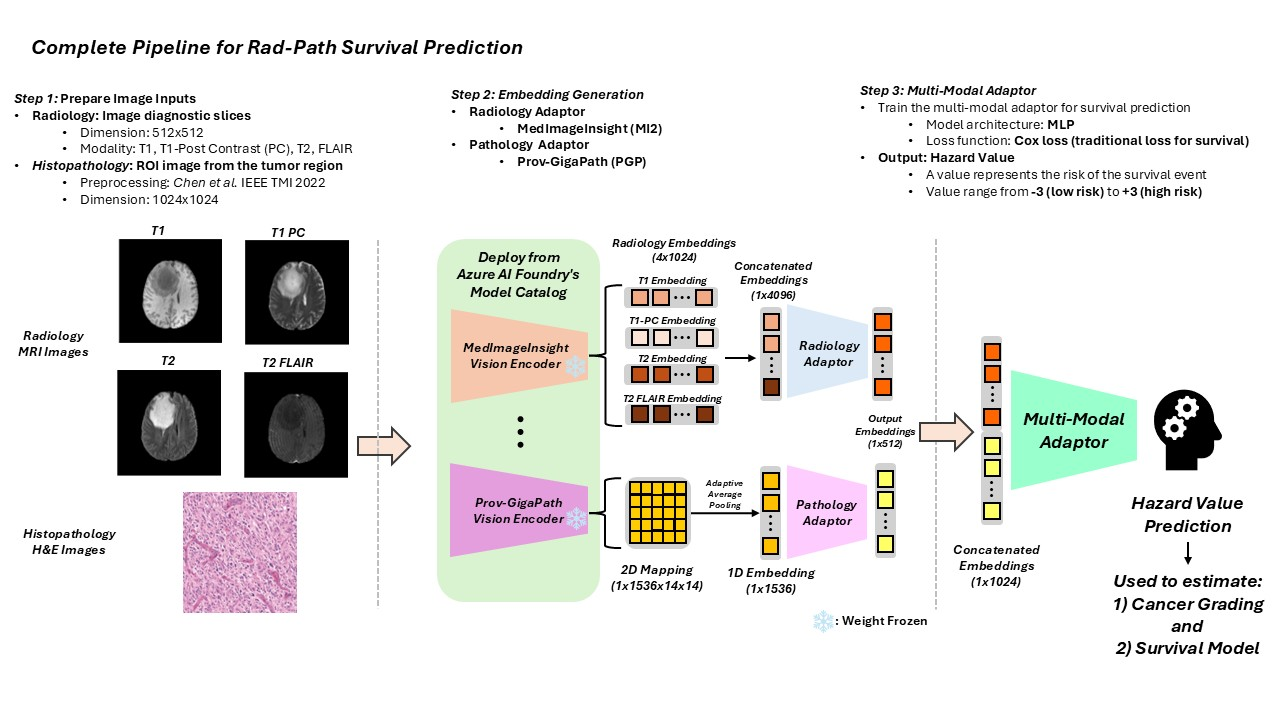
In this tutorial, we will guide you through the key steps from analyzing the multi-modality data, generating multi-modality embeddings to training adapter model and performing inference.  We first provide a high level understanding of each step as follows:

1. **Data Analysis** 
    - Plot bar chart to investigate the sample population for each tumor grading
    - Perform correlation analysis to investigate the population correspondence between the tumor grading and the survival months 
2. **Generate Image Embeddings for Multi-Modality Images (Optional)**
    - Adapt modality-specific foundation models to generate 1-D embeddings for medical downstream tasks
        - Radiology: **MedImageInsight (MI2)**
        - Pathology: **Prov-GigaPath (PGP)**
3. **Train Adapter Model for Survival Prediction**
    - Fuse radiology and pathology embeddings with simple neural network architecture (i.e. MLP)
    - Output **hazard value** that refers to the instantaneous risk of the event of interest (such as death, disease recurrence, or failure) occurring at a specific time point, given that the individual has survived up to that time.
4. **Perform Inference**
    - Use the output hazard value from the testing dataset to generate survival curve (i.e. Kaplan-Meier Survival Curve)



## What is Survival Prediction?

**Survival prediction** is a statistical approach used to estimate the time until an event of interest—such as death, disease recurrence, or progression—occurs in a population. It involves analyzing time-to-event data while accounting for censored observations (instances where the event has not occurred during the study period). Survival prediction models, such as the Cox proportional hazards model or machine learning algorithms like deep learning methods, compute hazard (risk of death) values based on various parameters. These parameters typically include patient demographics (age, sex), clinical features (tumor grade, stage), treatment details, molecular biomarkers (genetic mutations, protein expressions), and imaging data (MRI scans, pathology images). By incorporating these variables as covariates, the models can estimate hazard rates or survival functions, thereby predicting individual or group survival outcomes and aiding in personalized medicine and treatment planning. More details about survival prediction can be found here: [Paper](https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2024.1428501/full)

In this tutorial, we will provide step-by-step guidance starting from extracting meaningful features from multi-modality imaging data to integrating features to train model for survival prediction. Let's get started!

In [1]:
## Load Packages for the tutorial
import pandas as pd
import torch
import os
import numpy as np
from survival_demo_utils import (
    SurvivalModel,
    create_survival_data_loader,
    survival_trainer,
    perform_survival_inference,
    load_trained_model,
    read_nifti_client,
    plot_survival_curve,
    plot_grade_distribution_correspondence,
    visualize_radiology_pathology_images,
    plot_gt_and_pred_survival_curves,
    visualize_radiology_pathology_images_with_pred_grade,
)
from healthcareai_toolkit.clients import MedImageInsightClient, GigaPathClient
from healthcareai_toolkit import settings
from tqdm import tqdm
import pickle
import glob

## 1. Data Exploration
In this tutorial, we use [TCGA-GBMLGG](https://github.com/mahmoodlab/PathomicFusion/tree/master/data/TCGA_GBMLGG) dataset, a comprehensive resource from The Cancer Genome Atlas (TCGA) that combines data from both glioblastoma multiforme (GBM) and lower-grade gliomas (LGG). By utilizing this dataset, we aim to perform survival prediction across the full spectrum of glioma malignancy.
- **Glioblastoma multiforme (GBM)**: the most aggressive form of brain tumor, classified as World Health Organization (WHO) grade IV. It is characterized by rapid growth and a poor prognosis due to its highly invasive nature and resistance to conventional therapies.

- **Lower-Grade Gliomas (LGG)**: Less aggressive brain tumors, classified as WHO grades II and III. They tend to grow more slowly and have a better initial prognosis compared to GBM. However, LGGs can progress to higher-grade tumors over time.

By combining data from both GBM and LGG, the TCGA-GBMLGG dataset enables comprehensive studies across the spectrum of glioma malignancy. This integrated approach facilitates insights to  utilize different functional context (i.e. tumor progression) for impactful downstream tasks, especially survival prediction.

### 1.1 Data Setup

In this tutorial, we are using TCGA-GBMLGG dataset that consists of mainly two imaging modalities and csv files for performing survival prediction: 
1. Radiology Diagnostic Slices
    - Contains diagnostic brain MRI slides for 170 subjects, each in 2D with a resolution of 512x512 pixels.
    - MRI slices use variable echo sequences (e.g., T1, T2, and FLAIR) to provide different imaging perspectives.
    - Each diagnostic slice is associated with a binary tumor segmentation label, indicating the presence or absence of a tumor.

2. Pathology Images
    - Includes 1 pathology image (1024x1024) extracted from tumor region for each subject, taken from H&E stained images.
    - Pathology patches are associated with two labels:
        - **Categorical tumor staging** label (Grade 0, 1, or 2).
        - **Survival Dates** label, indicating the recorded survival duration for each subject.

3. Survival Demo Label
    - Location: `/home/azureuser/data/healthcare-ai/advanced-radpath-demo/survival_demo_label.csv`
    - A summary file providing all subject-wise labels, including both **tumor staging** and **survival month** information.

4. Survival Data Split for Training & Testing:
    - Location: 
        - Training: `/home/azureuser/data/healthcare-ai/advanced-radpath-demo/survival_adapter_train_split.csv` 
        - Testing: `/home/azureuser/data/healthcare-ai/advanced-radpath-demo/survival_adapter_test_split.csv`
    - Csv files containing training and testing split to train the adapter model for survival prediction

### 1.2 Data Analysis

#### 1.2.1 Tumor Staging Analysis
- We initially conducted a tumor staging analysis to gain insight into the dataset's distribution and demographic composition. The dataset comprises 170 subjects categorized into three distinct tumor grades, with a relatively balanced distribution:
    - **Grade 0 (Early Stage)**: 40 subjects  
    - **Grade 1 (Intermediate Stage)**: 53 subjects  
    - **Grade 2 (Advanced Stage)**: 77 subjects, representing a slight predominance of higher-grade tumors.
  
#### 1.2.2 Correlation Analysis: Tumor Grading and Survival Months
- To explore the relationship between tumor grading and survival outcomes, we performed a correlation analysis, uncovering several trends:
    - **Survival Variability in Early-Stage Tumors**: Subjects with **Grade 0 (Early Stage)** tumors display the widest range in survival months, potentially reflecting variability in early-stage treatment responses or patient-specific biological factors that influence prognosis.

    - **Narrowing Survival Range in Higher Grades**: As tumor grades increase, the range of survival months becomes progressively narrower. This trend suggests that advanced-stage tumors lead to a more predictable, albeit shorter, survival period, highlighting the severity’s impact on prognosis.

    - **Impact of Tumor Severity on Survival Outlook**: The data reveal a negative correlation between tumor grading and survival duration, emphasizing the importance of early diagnosis. Higher grades (e.g., Grade 2) demonstrate uniformly shorter survival periods, reinforcing the clinical need for early intervention.
    
    - **Validation through Visualization**: Visual mapping of survival years across each grade corroborates and quantifies this decreasing survival trend with advancing tumor severity. This finding further supports the value of tumor staging in clinical decision-making and patient management strategies.


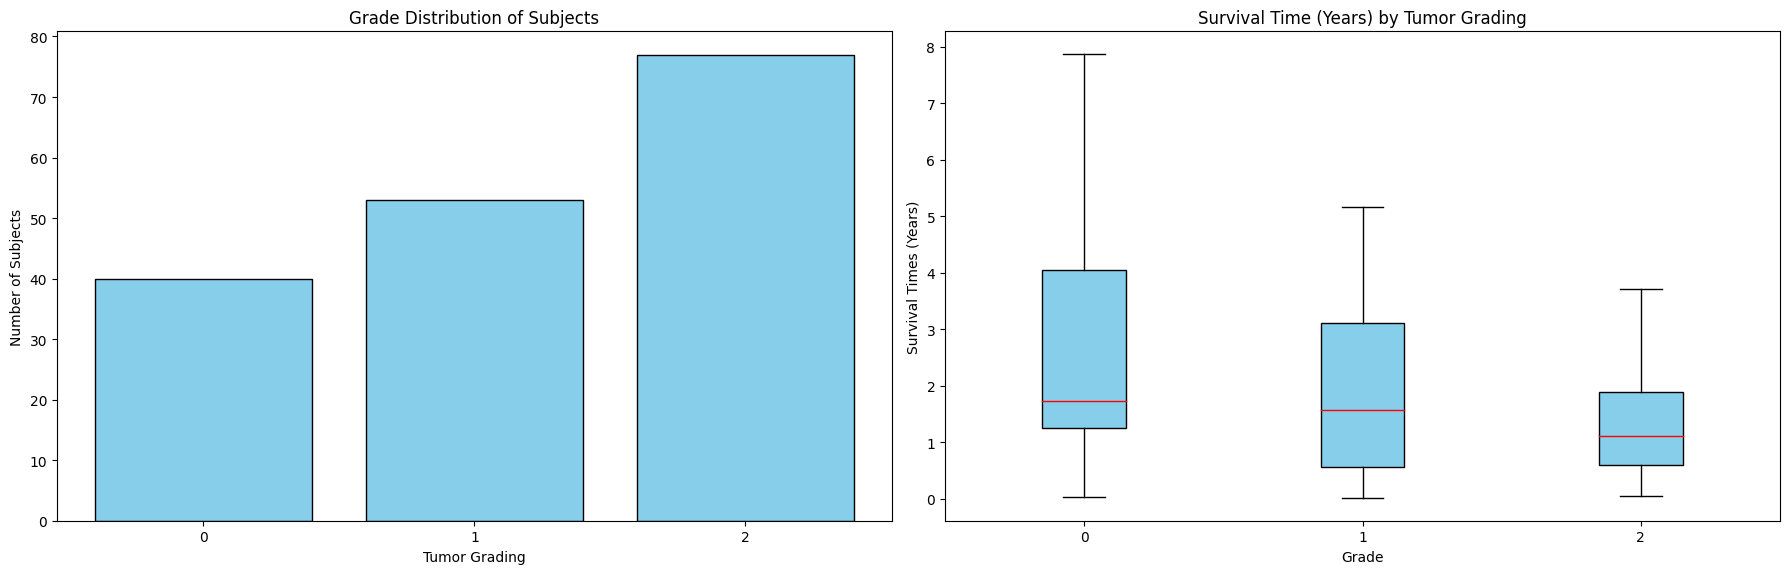

In [2]:
### Perform Data Analysis
## Load the root folder of the data
data_root = settings.DATA_ROOT

# Path to the CSV file
csv_file_path = os.path.join(
    data_root, "advanced-radpath-demo", "survival_demo_label.csv"
)

# Used the radiology data subjects information to filter csv data
radiology_embeddings_folder = os.path.join(
    data_root, "advanced-radpath-demo", "radiology_embeddings"
)

# Plot the censored status and grade distribution respect to survival months
plot_grade_distribution_correspondence(csv_file_path, radiology_embeddings_folder)

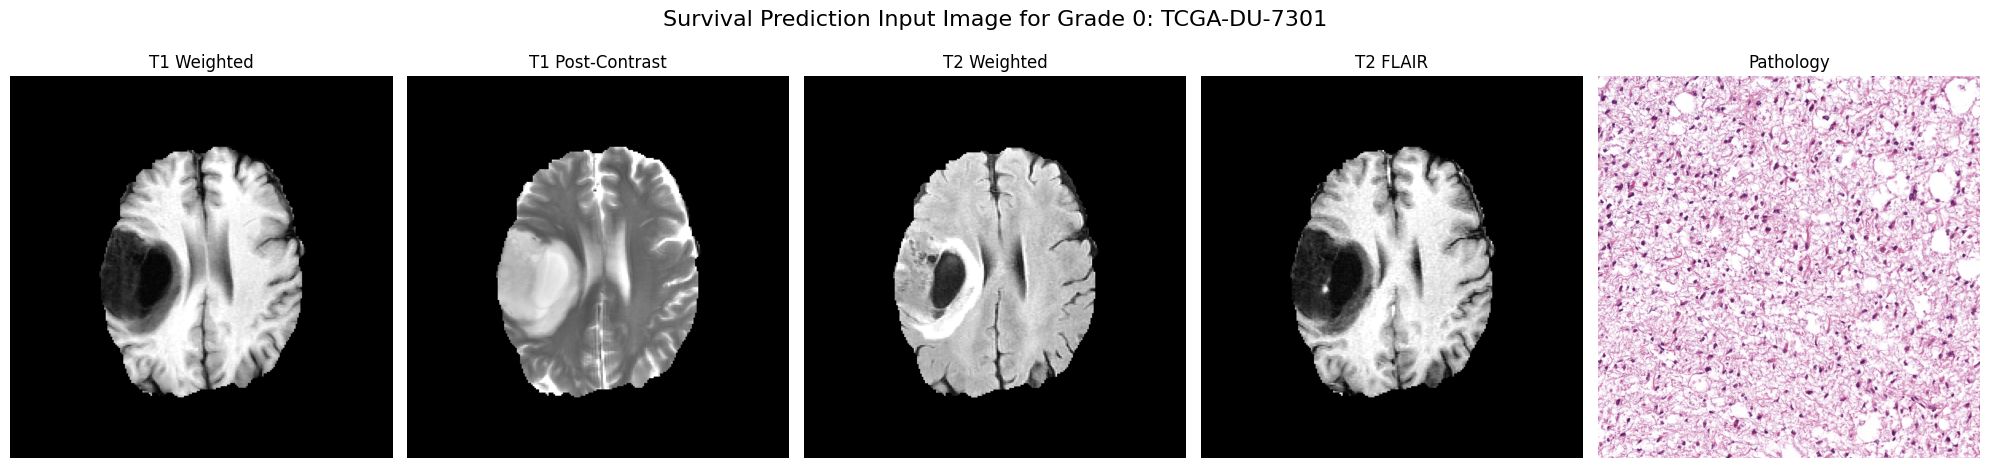

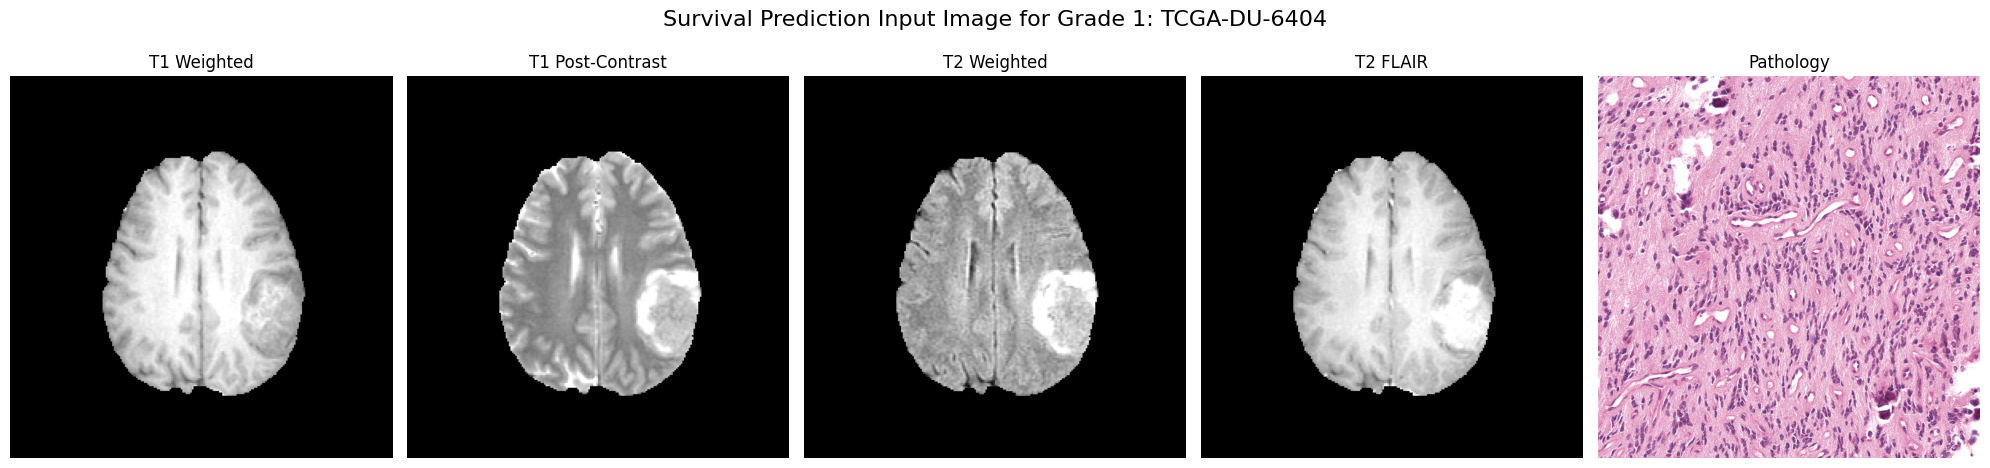

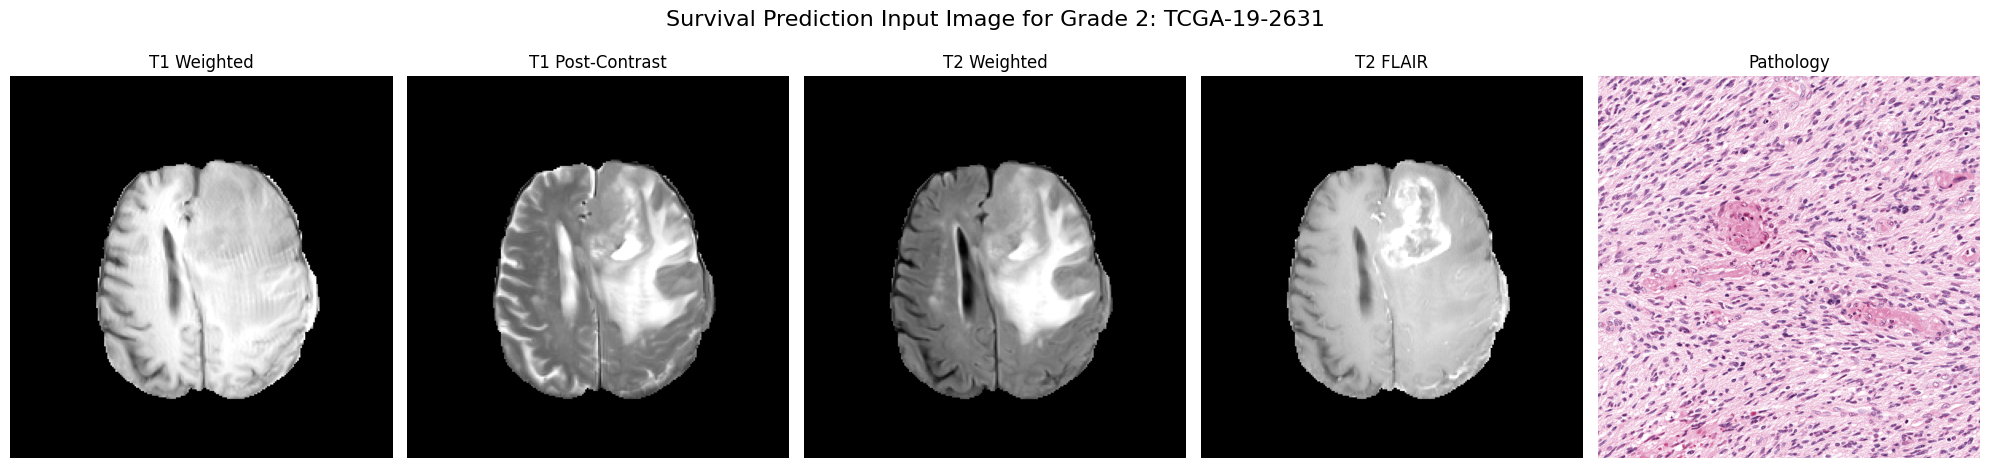

In [3]:
## Visualize Diagnostic Slices and Pathology Patches
# Provided Sample Images
radiology_sample_image = os.path.join(
    data_root, "advanced-radpath-demo", "sample_images", "radiology"
)
pathology_sample_image = os.path.join(
    data_root, "advanced-radpath-demo", "sample_images", "pathology"
)
visualize_radiology_pathology_images(
    csv_file_path, radiology_sample_image, pathology_sample_image
)

### 1.2.3 Kaplan-Meier Survival Curve Analysis

The Kaplan-Meier Survival Curve is a visual tool used to estimate survival probabilities over time. Below is a summary of the key elements and insights from the plot:

1. **Y-axis (Survival Probability):** Represents the probability that a subject will survive beyond a certain time point, starting at 1.0 (or 100%) at the beginning of the observation period and decreasing over time.

2. **X-axis (Survival Time in Years):** Shows the survival time in years, extending up to approximately 12.5 years. This duration reflects the period over which survival probabilities are tracked and estimated.

3. **Survival Curves by Tumor Grade:**

    - **Grade 0 (Blue Line):** Represents the survival probability for subjects with Grade 0 tumors. The curve shows the highest survival probability, with a slower decline over time and many subjects surviving for longer durations.
    - **Grade 1 (Orange Line):** Represents the survival probability for subjects with Grade 1 tumors. The curve declines more rapidly than Grade 0, indicating a moderate decrease in survival probability over time.
    - **Grade 2 (Red Line):** Represents the survival probability for subjects with Grade 2 tumors. The curve shows the steepest decline, indicating the lowest survival probabilities, with most subjects not surviving beyond 3 years.

4. **Censoring (Positive Marks):** The positive marks on the survival curves indicate censoring events-that is, a patient who was still alive (or event‐free) at their last follow‐up or was lost to follow‐up at that time. These marks show where the data for that patient ends, and the curve does not incorporate any information beyond that point for that individual.

5. **Interpretation of Survival Trends:**
    - **Grade 0 Tumors:** Patients with Grade 0 tumors exhibit the highest survival probabilities, with only a gradual decline over time. Long-term survival is achievable for many subjects.
    - **Grade 1 Tumors:** A moderate survival decline is observed, with survival probabilities falling steadily but less sharply compared to Grade 2 tumors.
    - **Grade 2 Tumors:** These patients have the poorest prognosis, with survival probabilities declining rapidly within the first few years of observation.
    
In summary, this Kaplan-Meier curve highlights survival disparities based on tumor grade. Subjects with Grade 0 tumors have the best survival outcomes, while those with Grade 2 tumors experience the most significant decline in survival probabilities. The vertical censoring marks provide insight into the timing of incomplete data observations.

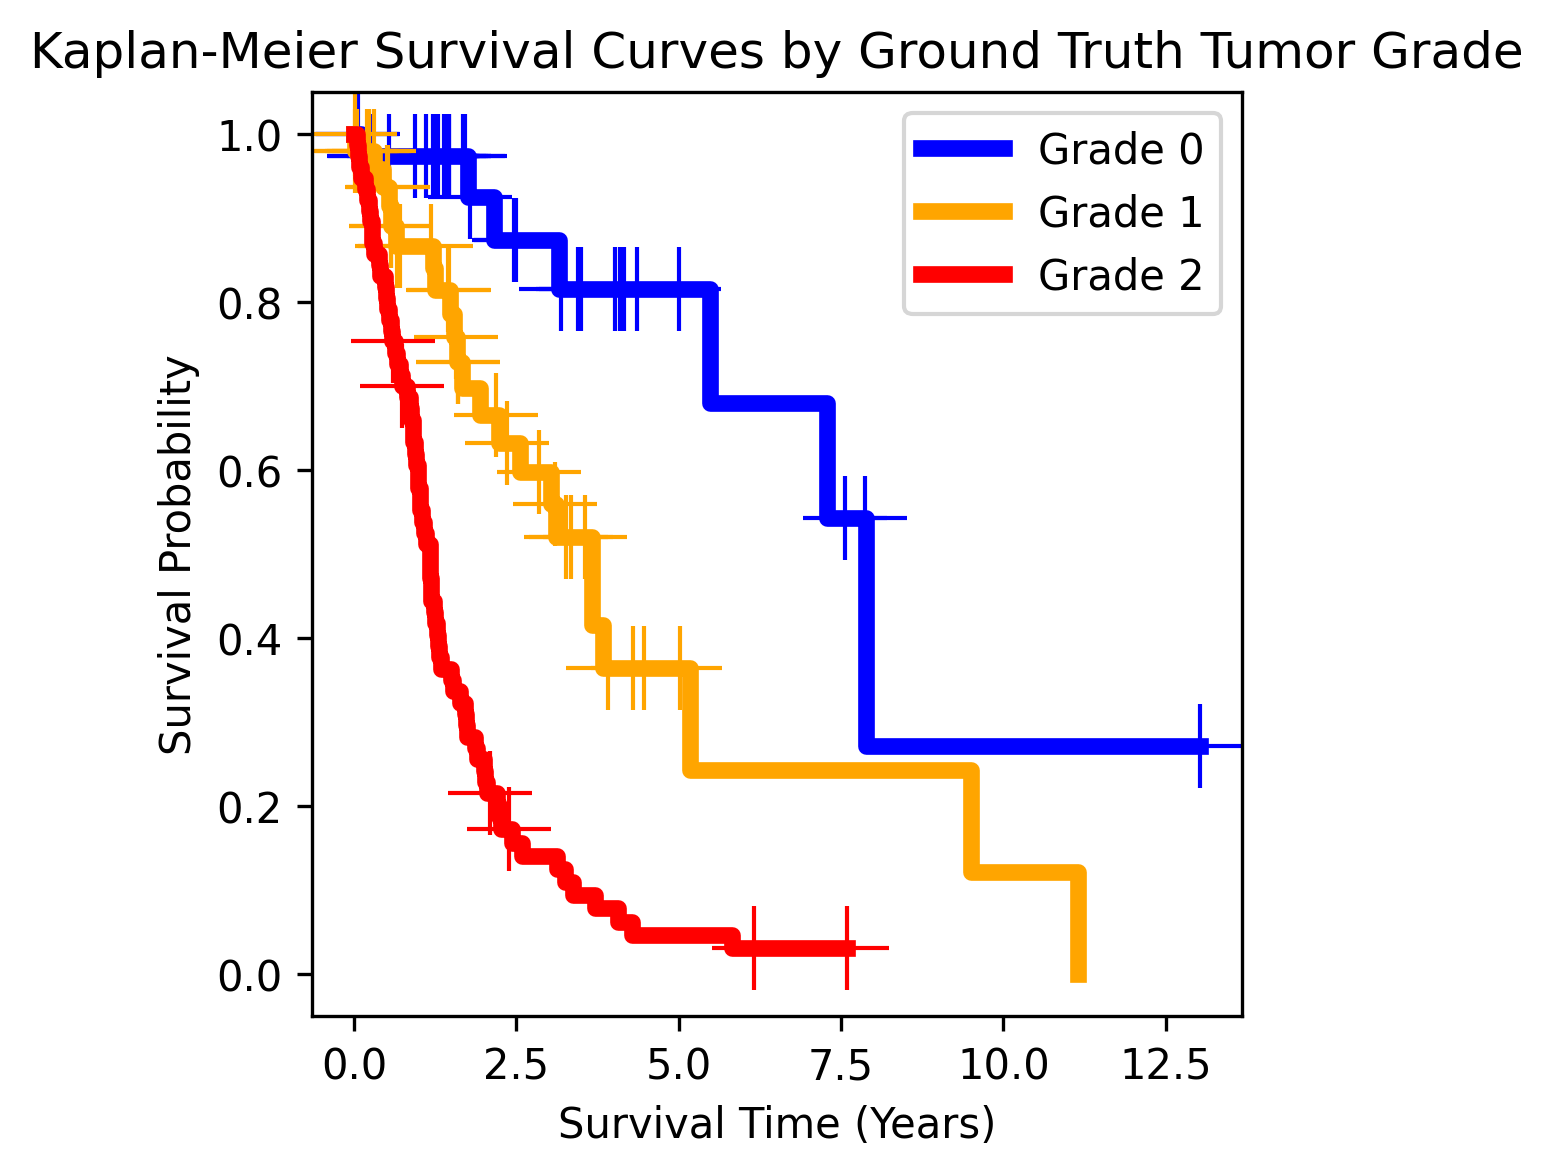

In [4]:
# Plot Kaplan Meier Survival Curve (All Patients, Training Split Subjects, Testing Split Subjects)
survival_csv = os.path.join(
    data_root, "advanced-radpath-demo", "survival_demo_label.csv"
)

plot_survival_curve(survival_csv, radiology_embeddings_folder, split=False)

## 2. Training Adapter Model with Multi-Modality Embeddings 

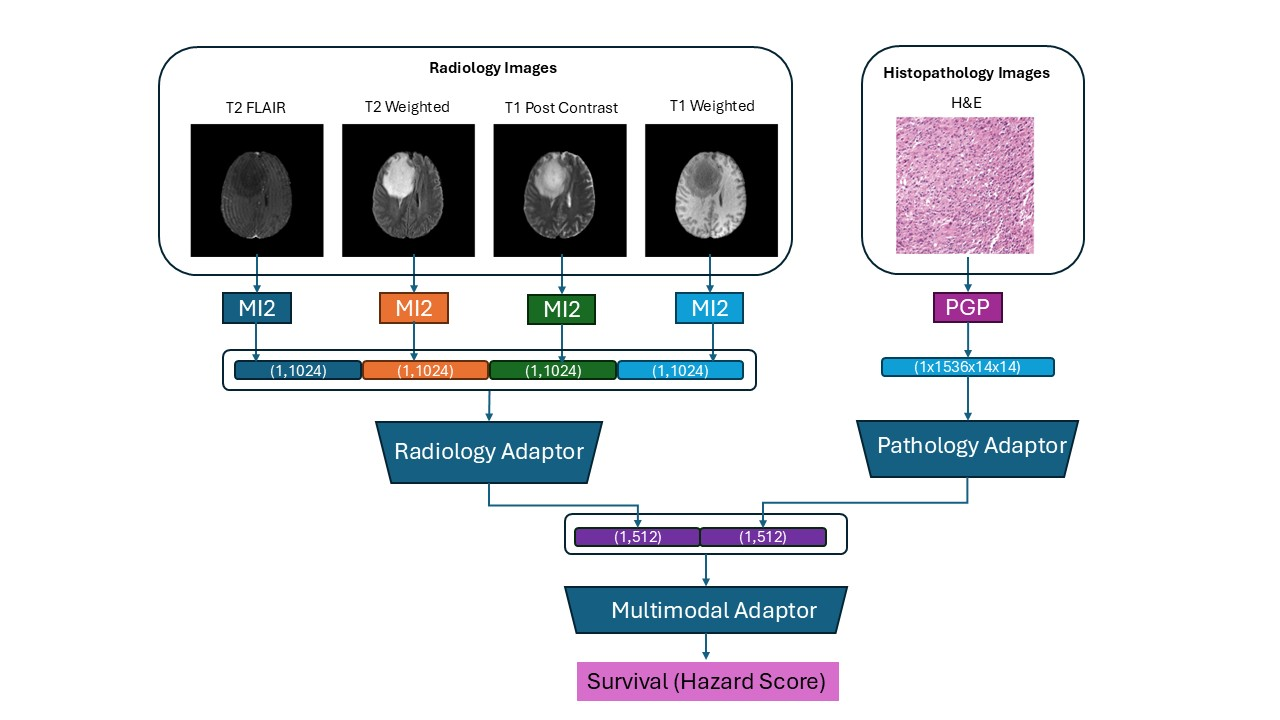

This section demonstrates how to leverage radiology and pathology image embeddings to train an adapter model for new downstream tasks in survival prediction. The process is divided into two main steps:

### 2.1. Generate Image Embeddings with Foundation Models (Optional)

Before we dive into the embedding generation process, we first split the dataset into training and testing sets. Both training and testing splits are specified in the corresponding CSV files:
- Training set: `/home/azureuser/data/healthcare-ai/advanced-radpath-demo/survival_adapter_train_split.csv`
- Testing set: `/home/azureuser/data/healthcare-ai/advanced-radpath-demo/survival_adapter_test_split.csv`

After performing the data split manually, we generate image embeddings with the foundation models in [Azure AI model catalog](https://ai.azure.com/explore/models?tid=72f988bf-86f1-41af-91ab-2d7cd011db47) with respect to imaging modality. Here is the summary of the foundation models that we leverage in this tutorial:

- **Radiology Foundation Model: [MedImageInsight (MI2)](https://ai.azure.com/explore/models/MedImageInsight/version/3/registry/azureml?tid=72f988bf-86f1-41af-91ab-2d7cd011db47)**
    - **Input:** Radiology Images (e.g., X-Ray, CT, MRI), medical text (optional)
    - **Output:** 1-D embedding (Dimension: 1x1024)
    - More experimental details can be found here: [Paper](https://arxiv.org/abs/2410.06542)

- **Pathology Foundation Model: [Prov-GigaPath (PGP)](https://ai.azure.com/explore/models/Prov-GigaPath/version/1/registry/azureml?tid=72f988bf-86f1-41af-91ab-2d7cd011db47)**
    - **Input:** Pathology Image (e.g., H&E staining images)
    - **Output:** 2-D Feature Map (Dimension: 1x1536x14x14)
    - More experimental details can be found here: [Paper](https://www.nature.com/articles/s41586-024-07441-w)

As we have provided the embeddings as convenience for this tutorial, this step is completely optional!

### 2.2. Training Adapter for Survival Prediction

To adapt to new downstream tasks like survival prediction, training a new adapter model is an efficient alternative to perform new capabilities using the feature embeddings only. Additionally, [Can et al.](https://arxiv.org/abs/2203.04419) demonstrate the capability of performing survival prediction with modality-specific model-generated embeddings. With such insight, we hypothesize that leveraging the embeddings generated from foundation models can demonstrate similar capabilities towards survival prediction.

We first define the architecture of the adapter model, which is a 4-layer Multi-Layer Perceptron (MLP), and the loss function specific for survival prediction.

- **Survival Labels:**
    - **Survival Dates:** How many days the patient has survived
    - **Censored:** Whether the patient is still alive or not (0: Alive, 1: Death)

- **Adapter Architecture and Training Parameters:**
    - **Architecture:** 4-layer MLP Model
    - **Hyperparameters:**
        - **Optimizer:** AdamW
        - **Learning Rate:** 0.0002
        - **Batch Size:** 16

- **Loss Function:**
    - **Negative log partial likelihood** from the Cox model (traditional survival model) served as the loss function
    - **Intuition behind the loss function:**
        - **Ranking Patients:** The loss function focuses on the relative ordering of predicted risk scores, encouraging the model to correctly rank patients according to their risk.
        - **Pairwise Comparisons:** It can be viewed as performing pairwise comparisons between patients who experienced the event and those still at risk.
        - **Survival Analysis Suitability:** The loss function aligns with the goals of survival analysis, handling censored data effectively and not requiring assumptions about the baseline hazard function.




### 2.1 Generate Embeddings for Radiology and Pathology Images 

In this section, we provide a tutorial on how to generate image embeddings for both radiology and pathology images using the corresponding foundation models. The embeddings are crucial for training the adapter model for survival prediction. 

Specially mentioned that **we don't need to run this cell**, as we already provide the features for demo purposes.

#### Steps to Generate Embeddings 
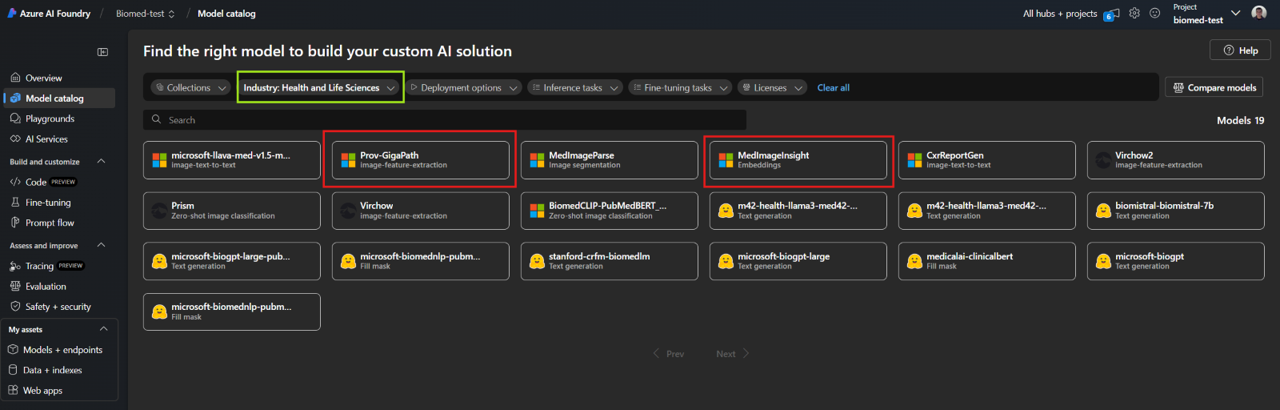
1. **Deploying Modality-Specific Foundation Model Clients for Embedding Generation**:
    - We provide both MedImageInsight client and GigaPath client functions to directly submit multiple images as a list to the online endpoint for generating corresponding image embeddings. The endpoint information will be generated once the foundation model is deployed in **Azure AI Model Catalog** (i.e. the above screenshot) and has to be input in the below file location before running the client:
        - **Endpoint URL**: Input specific endpoint information into the [.env file](../../../env.example)
    - We save each output feature as a pkl file with respect to subjects. 

2. **Organizing Outputs**:
    - The generated embeddings are organized into a dictionary with respect to the subject name. This structured organization facilitates easy access and further processing during model training.

In [ ]:
## Define image folders locally if you want to generate embeddings for your own datasets
diagnostic_slice_folder = ""
pathology_patch_folder = ""

## Define MedImageInsight Client
mi2_client = MedImageInsightClient()
mi2_submitter = mi2_client.create_submitter()

# ## Generate radiology embeddings with MedImageInsight
name_list = []
subj_list = []
image_list = []
output_radiology_folder = os.path.join("./data", "radiology_embeddings")
if not os.path.exists(output_radiology_folder):
    os.makedirs(output_radiology_folder)

for image in os.listdir(diagnostic_slice_folder):
    if "_000" in image:
        name = image.split(".nii.gz")[0]
        subj = name.split("_")[0]
        name_list.append(name)
        if subj not in subj_list:
            subj_list.append(subj)
        image_file = os.path.join(diagnostic_slice_folder, image)
        image_list.append(read_nifti_client(image_file))  ## Specify for nifti files

## Submit the images to the MI2 client
_, radiology_results = mi2_submitter.submit(
    image_list=image_list, total=len(image_list)
)

# Save the radiology embeddings as pkl files to the output folder
for i in range(len(radiology_results)):
    radiology_embedding = np.array(radiology_results[i]["image_features"][0])
    output_pkl_file = os.path.join(output_radiology_folder, name_list[i] + ".pkl")
    with open(output_pkl_file, "wb") as f:
        pickle.dump(radiology_embedding, f)
print("--------Finished Generating Radiology Embeddings!!--------")

## ------------------------------------------------------------------------------------------------------- ##

## Generate Pathology Embeddings with GigaPath Client
## Define GigaPath Client
gigapath_client = GigaPathClient()
gigapath_submitter = gigapath_client.create_submitter()

## Submit the images to the GigaPath client
pathology_image_list = []
output_pathology_folder = os.path.join("./data", "pathology_embeddings")
if not os.path.exists(output_pathology_folder):
    os.makedirs(output_pathology_folder)

for subj in tqdm(subj_list):
    tumor_region = glob.glob(os.path.join(pathology_patch_folder, subj + "*"))[0]
    pathology_image_list.append(tumor_region)

_, pathology_results = gigapath_submitter.submit(
    image_list=pathology_image_list, total=len(pathology_image_list)
)

# Save the pathology embeddings as pkl files to the output folder
for i in range(len(pathology_results)):
    pathology_embedding = pathology_results[i]["image_features"]
    output_pkl_file = os.path.join(output_pathology_folder, subj_list[i] + ".pkl")
    with open(output_pkl_file, "wb") as f:
        pickle.dump(pathology_embedding, f)
print("--------Finished Generating Pathology Embeddings!!--------")

Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [01:57<00:00,  5.78it/s]


--------Finished Generating Radiology Embeddings!!--------
Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [05:32<00:00,  1.96s/it]


--------Finished Generating Pathology Embeddings!!--------


### 2.2 Load Embeddings for Adapter Training and Testing

In this section, we prepare the precomputed image embeddings and labels for training and validation by creating respective DataLoaders for the downstream model training.

1. First, we load the `radiology_embeddings` and `pathology_embeddings` generated in the previous step and use the `SurvivalDataset` class to create datasets for training and validation. We input the corresponding data split CSV files (`survival_adapter_train_split.csv` and `survival_adapter_test_split.csv`) along with the embeddings into the `SurvivalDataset`.
2. We then create DataLoaders `train_loader` and `val_loader` using these datasets, specifying parameters like batch size and shuffle. These DataLoaders enable efficient batch processing of data during the training and validation of the adapter model.

In [5]:
print("----------Loading Features into DataLoader----------")
# Load the embedding pkl file for radiology and pathology images
radiology_embeddings_folder = os.path.join(
    data_root, "advanced-radpath-demo", "radiology_embeddings"
)
pathology_embeddings_folder = os.path.join(
    data_root, "advanced-radpath-demo", "pathology_embeddings"
)

## Load all radiology embeddings into a dictionary for training efficiency
radiology_embeddings = {}
for file in os.listdir(radiology_embeddings_folder):
    if file.endswith(".pkl"):
        subj = file.split("_")[0]
        modality = file.split("_")[1].split(".pkl")[0]
        with open(os.path.join(radiology_embeddings_folder, file), "rb") as f:
            if subj not in radiology_embeddings:
                radiology_embeddings[subj] = {}
            radiology_embeddings[subj][modality] = {}
            radiology_embeddings[subj][modality] = pickle.load(f)

## Load all pathology embeddings into a dictionary for training efficiency
pathology_embeddings = {}
for file in os.listdir(pathology_embeddings_folder):
    if file.endswith(".pkl"):
        subj = file.split(".pkl")[0]
        with open(os.path.join(pathology_embeddings_folder, file), "rb") as f:
            pathology_embeddings[subj] = pickle.load(f)

# Load the training and validation CSV files
train_csv_path = os.path.join(
    data_root, "advanced-radpath-demo", "survival_adapter_train_split.csv"
)
val_csv_path = os.path.join(
    data_root, "advanced-radpath-demo", "survival_adapter_test_split.csv"
)

# Create DataLoader for training and validation datasets
train_loader = create_survival_data_loader(
    csv=train_csv_path,
    radiology_embeddings=radiology_embeddings,
    pathology_embeddings=pathology_embeddings,
    mode="train",
    batch_size=16,
    num_workers=2,
    pin_memory=True,
)
val_loader = create_survival_data_loader(
    csv=val_csv_path,
    radiology_embeddings=radiology_embeddings,
    pathology_embeddings=pathology_embeddings,
    mode="test",
    batch_size=16,
    num_workers=2,
    pin_memory=True,
)

----------Loading Features into DataLoader----------


### 2.3 Adapter Model Architecture for Survival Prediction

In the practical application of embedding models, adapters emerge as essential components. These compact neural networks are designed to take embeddings as input and output either classes or new embeddings. Adapters enhance classification performance and uncover correlations across different modalities, making them indispensable for multi-modal analyses. 

The figure in the beginning of section 2 illustrates the use of three adapters in this workflow: 
- **Radiology Adapter:** Receives a 4096-sized vector (i.e. 4x1024 -> flatten), representing a concatenation of embeddings from four slices across different radiological modalities. 
- **Pathology Adapter:** Processes a feature tensor of size 1536×14×14, generated by the PGP model from histopathology slide regions of interest (ROIs). 
- **Multi-Modal Adapter:** Combines the outputs of the radiology and pathology adapters—refined into a unified 1024-sized vector—and converts this into a final hazard score. 

#### Initialize Your Own Adapter Model
After successfully loading all image embeddings, we proceed to initialize the adapter model for survival prediction by setting several key parameters and components as follows:

1. The number of output classes (`num_class`): 1, matching the survival output class (i.e. hazard value)
2. The hidden layer dimension (`hidden_dim`): 512, providing a default model hidden dimension
3. The input channels for radiology (`in_channels_rad`): 1024, matching the MedImageInsight embedding dimension of 1024 to ensure compatibility
4. The input channels for pathology (`in_channels_path`): 1536, matching the GigaPath embedding dimension of 1536 to ensure compatibility
5. The learning rate (`learning_rate`): 0.0002
6. Optimizer (`optimizer`): AdamW

We then create the adapter model and here we construct a multi-layer perceptron (MLP) with the above specifications. Finally, we define the output directory `output_dir` where the trained model and related outputs will be saved, ensuring the directory exists or is created if it doesn't.

In [6]:
# Initialize the model, optimizer, and loss function
## Survival output classes
num_class = 1
## Hidden dimensions of the adapter model feature
hidden_dim = 512
## Input Radiology and Pathology channels
in_channels_rad = 1024  ## Matching the input channel of the adapter model with the MedImageInsight embeddings channels
in_channels_path = 1536  ## Matching the input channel of the adapter model with the GigaPath embeddings channels
learning_rate = 0.0002
print("Learning rate: {}".format(learning_rate))

## Define the model and optimizer
model = SurvivalModel(in_channels_rad, in_channels_path, hidden_dim, num_class)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print("Optimizer for training: {}".format(optimizer))

## Define Output Directory
output_dir = os.path.join("./survival_model_output", "adapter_model")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Learning rate: 0.0002
Optimizer for training: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0.01
)


**Training the Adapter Model**

In this section, we train the adapter model using the prepared training and validation DataLoaders. We only need to train such a small model with **~14 seconds** to have a performance boost in accuracy. We set the maximum number of training epochs and initiate the training process:
- **Maximum Epochs** (max_epoch): We set the number of training epochs to 30, which determines how many times the model will iterate over the entire training dataset.

We then call the training function:
`trainer` Function: This function handles the training loop, validation, and performance tracking.
- Input Parameters: 
    1. `train_loader`: The DataLoader for the training dataset
    2. `val_loader`: The DataLoader for the validation dataset
    3. `model`: The adapter model to be trained
    4. `optimizer`: The optimizer (`AdamW`) initialized earlier
    5. `epochs`: Number of Epochs to train the model (`max_epoch`)
    6. `root_dir`: Directory to save model checkpoints and logs (`output_dir`)

After training, the function returns the best C-Index `best_cindex` achieved on the validation set. 


In [7]:
max_epoch = 30
result_dict = survival_trainer(
    train_loader, val_loader, model, optimizer, epochs=max_epoch, root_dir=output_dir
)
print(f'Best C-Index of the Adapter: {result_dict["best_cindex"]:.4f}')

Current epoch: 30 Current C-Index: 0.7251 Best C-Index: 0.8036 at epoch: 7
Total Training Time: 00:00:19.16
Training completed, Best C-Index: 0.8036 at epoch: 7
Best C-Index of the Adapter: 0.8036


## 3. Perform Inference to Predict Survival Risk
After training our adapter model on the TCGA-GBMLGG dataset to predict survival outcomes, we proceed to the inference stage. In this phase, we apply the trained model to new, unseen data to predict the survival risk for each patient.

- **4.1 Inference on Test Data**
    
    We utilize the test split of our dataset to evaluate the model's performance. During inference, the model processes input data—such as imaging features from MRI slices and pathology images—and outputs a **hazard score** for each subject.
    - **Understanding the Model Output**: The output of the model is a set of Hazard scores, which are continuous numerical values representing each patient's relative risk of experiencing the event (e.g., death) earlier.
        - **Higher Hazard Scores:** Indicate a higher predicted hazard, meaning the patient is more likely to experience the event sooner.

        - **Lower Hazard Scores:** Suggest a lower predicted hazard, indicating a longer expected survival time.

    More details of how to perform and analyze the survival predictions from the adapter model can be found throughout our blogpost: [Blog]() (i.e. will add the blogpost link once the blog is posted)
    
    - **Evaluate Model Performance**: We assess the model's predictive ability using metrics common in survival analysis:
        - **Concordance Index (C-Index):** Measures how well the predicted risk scores correlate with actual survival times.
        - **Results Interpretation:** 
            - C-Index close to 1.0: Excellent model predictive ability.
            - C-Index around 0.5: No better than random chance.   
        - **Censored Prediction Accuracy:** Adapt risk scores to predict whether the patient is alive or not.
    
    - **Converting Hazard Scores to Survival Predictions**: While Hazard scores provide a relative ranking, we often want to translate these into more interpretable survival predictions. This can involve:
        - **Hazard Stratification:** Dividing patients into risk groups (e.g., high-risk vs. low-risk) based on percentiles of Hazard predictions.
            -  **Low** / **intermediate** / **High**: 33 - 66 - 100 Percentile 
        - **Survival Function Estimation:** Using statistical methods to estimate survival probabilities over time.

- **4.2 Visualize Survival Predictions**
    
    We plot Kaplan-Meier survival curves for the high-risk and low-risk groups to visualize the difference in survival probabilities over time. 
    

In [7]:
model_path = os.path.join(output_dir, "best_metric_model.pth")
model_inference = load_trained_model(model, model_path)
results, prediction = perform_survival_inference(model_inference, val_loader)
print(f'C-Index of the Adapter: {results["cindex"]:.4f}')
print(f'Censored Prediction Accuracy of the Adapter: {results["survival_acc"]:.4f}')

C-Index of the Adapter: 0.8036
Censored Prediction Accuracy of the Adapter: 0.8571


### Hazard Stratification
This section of the code is inspired by the work of [Chen et al.](https://arxiv.org/abs/1912.08937).bIt involves stratifying predicted hazard values into multiple spectrums and hypothesizing that each spectrum's risk level corresponds to tumor grade distribution. The goal is to provide a clinically relevant interpretation by aligning stratified risk groups with tumor grades. This involves mapping the predicted risk groups to the corresponding tumor grades observed in the dataset:

**Aligning Risk Groups to Tumor Grades**:
- **Low Risk (Grade 0)**: Patients in the lowest 33rd percentile of hazard scores are considered low risk. These patients typically have early-stage tumors (Grade 0) with better prognosis and longer survival times.
- **Intermediate Risk (Grade 1)**: Patients in the 34th to 66th percentile of hazard scores fall into the intermediate risk category. These patients usually have intermediate-stage tumors (Grade 1) with moderate prognosis and survival times.
- **High Risk (Grade 2)**: Patients in the highest 67th to 100th percentile of hazard scores are classified as high risk. These patients often have advanced-stage tumors (Grade 2) with poorer prognosis and shorter survival times.

By aligning the risk groups with tumor grades, the model's predictions can be more easily interpreted in a clinical context, aiding in treatment planning and patient management.

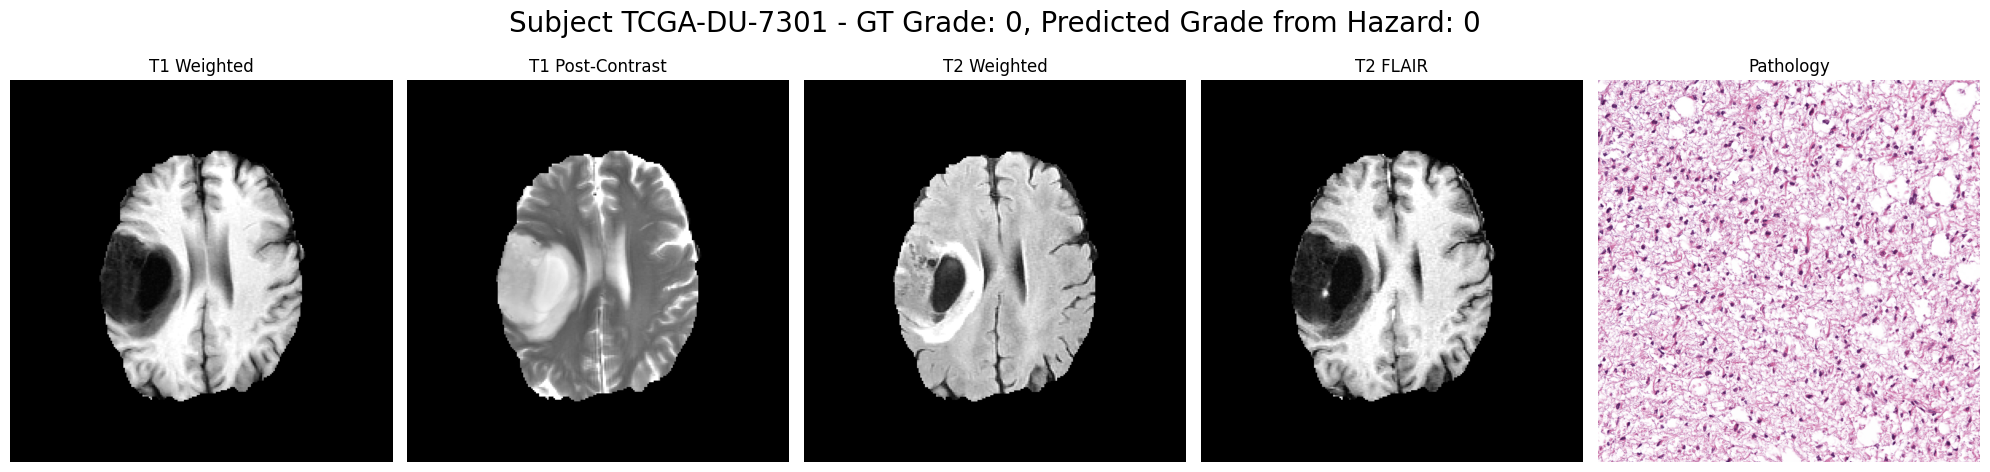

In [8]:
## Visualize the test images with the predicted grade and corresponding ground truth
visualize_radiology_pathology_images_with_pred_grade(
    val_csv_path,
    prediction,
    radiology_sample_image,
    pathology_sample_image,
    percentile=[33, 66],
)

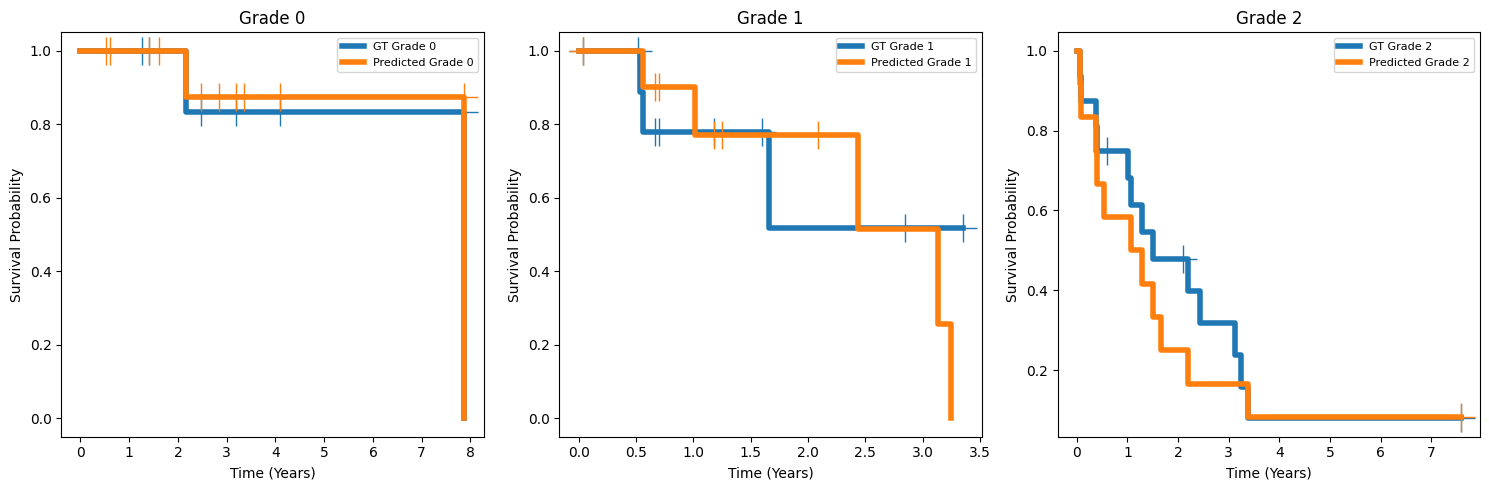

In [9]:
## Plot the survival curve with the predicted hazard and ground truth
plot_gt_and_pred_survival_curves(
    val_csv_path,
    prediction,
    radiology_folder=radiology_embeddings_folder,
    is_split=True,
    percentile=[33, 66],
)

### Key Observations of Each Curves with Respect to Grade
1) Grade 0 
    - Both GT and Predicted curves remain near 100% survival for most of the follow‐up, indicating very favorable outcomes.
    -  The Predicted curve dips sharply at around 7–8 years, whereas GT remains slightly higher, suggesting a late event that the model captured differently than the real data.

2) Grade 1 
    - Early on, the Predicted curve lies slightly below GT, indicating the model anticipates some events happening sooner.
    - Near 2–3 years, the GT curve drops more steeply, causing the two curves to cross (or nearly so).

3) Grade 2 
    - Both curves drop rapidly, reflecting poor outcomes typical of higher‐grade tumors.
    - The Predicted curve is consistently below GT, indicating the model tends to forecast slightly worse survival.

### Key Takeaways from the Survival Curves
1) Grade 0
    -  The model predictions for Grade 0 align closely with the GT overall, confirming low‐risk status.
    - The late dip is likely driven by a small number of events (or even a single event), so the difference is minor.

2) Grade 1
    - Both curves ultimately end in a similar survival range, so the model captures the general trajectory but differs in the timing of events.
    - These moderate declines fit the expected intermediate‐risk profile of Grade 1 tumors.

3) Grade 2
    - Despite a more pessimistic prediction, the model still reflects the aggressive nature of Grade 2 disease.
    - The steep decline within the first 2–3 years is consistent with high‐grade tumor behavior.


### Final Remarks of this Tutorial

From a survival prediction tutorial using foundation model embeddings, one can gain valuable insights into how advanced AI techniques can enhance risk stratification and survival analysis in clinical settings. This tutorial demonstrates how foundation models can be leveraged extract meaningful embeddings and use them to predict patient outcomes. By analyzing Kaplan-Meier survival curves derived from these predictions, learners can evaluate the model's ability to replicate ground truth trends and identify its strengths in low-risk group classification and weaknesses in distinguishing overlapping risk categories.

Key takeaways include the importance of data preprocessing, embedding selection, and the role of feature representation in improving model performance. Additionally, the tutorial highlights the utility of statistical validation and visualization techniques for interpreting model predictions and aligning them with clinical applications. This knowledge is crucial for developing scalable, accurate, and interpretable survival models that integrate seamlessly into real-world healthcare workflows.